In [1]:
import tensorflow as tf
import os
import zipfile
if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2024-01-08 08:00:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-01-08 08:00:27 (10.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
import os
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data, walk_through_dir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import tensorflow_hub as hub
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# How many images/classes are there?
unzip_data("/content/drive/MyDrive/animals.zip")
walk_through_dir("animals/dataset")

There are 3 directories and 0 images in 'animals/dataset'.
There are 7 directories and 0 images in 'animals/dataset/train'.
There are 0 directories and 525 images in 'animals/dataset/train/acinonyx-jubatus'.
There are 0 directories and 525 images in 'animals/dataset/train/ailuropoda-melanoleuca'.
There are 0 directories and 525 images in 'animals/dataset/train/gallus-gallus-domesticus'.
There are 0 directories and 525 images in 'animals/dataset/train/felis-catus'.
There are 0 directories and 525 images in 'animals/dataset/train/canis-lupus-familiaris'.
There are 0 directories and 525 images in 'animals/dataset/train/panthera-tigris'.
There are 0 directories and 525 images in 'animals/dataset/train/equus-caballus'.
There are 7 directories and 0 images in 'animals/dataset/test'.
There are 0 directories and 125 images in 'animals/dataset/test/acinonyx-jubatus'.
There are 0 directories and 125 images in 'animals/dataset/test/ailuropoda-melanoleuca'.
There are 0 directories and 125 images i

In [5]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "animals/dataset/train/"
test_dir = "animals/dataset/test/"
validation_dir = "animals/dataset/validation"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
validation_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size=IMAGE_SHAPE,
                                                batch_size=BATCH_SIZE,
                                                class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical",
                                             shuffle=False)

print("Validation images:")
validation_data = validation_datagen.flow_from_directory(validation_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical",
                                                         shuffle=False)

Training Images:
Found 3675 images belonging to 7 classes.
Testing images:
Found 875 images belonging to 7 classes.
Validation images:
Found 875 images belonging to 7 classes.


In [6]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [7]:
IMAGE_SHAPE += (3,)
def create_model(model_url,num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="Feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE)
  # create sequential model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation='softmax',name="output_layer")
  ])

  return model

In [8]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 7)                 14343     
                                                                 
Total params: 23579143 (89.95 MB)
Trainable params: 14343 (56.03 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [9]:
resnet_history = resnet_model.fit(train_data,
                 epochs=3,
                 steps_per_epoch=len(train_data),
                 validation_data=validation_data,
                 validation_steps=len(validation_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240108-080717
Epoch 1/3
115/115 [==============================] - 55s 393ms/step - loss: 0.2701 - accuracy: 0.9156 - val_loss: 0.2741 - val_accuracy: 0.9223
Epoch 2/3
115/115 [==============================] - 35s 301ms/step - loss: 0.0693 - accuracy: 0.9790 - val_loss: 0.2723 - val_accuracy: 0.9234
Epoch 3/3
115/115 [==============================] - 37s 319ms/step - loss: 0.0394 - accuracy: 0.9913 - val_loss: 0.3209 - val_accuracy: 0.9166


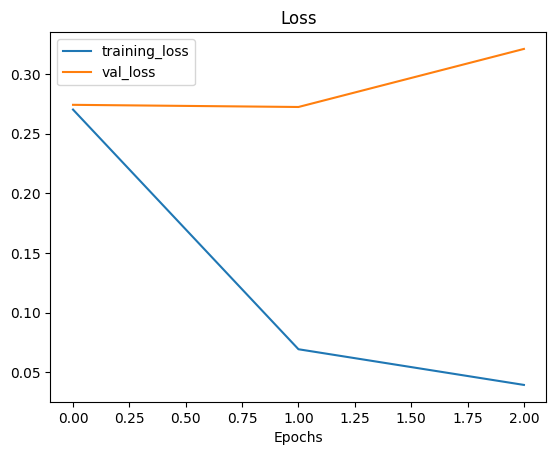

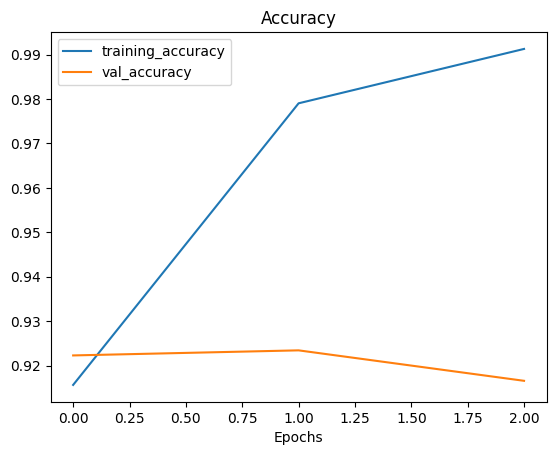

In [10]:
plot_loss_curves(resnet_history)

In [11]:
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data.num_classes)
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4058531 (15.48 MB)
Trainable params: 8967 (35.03 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [12]:
efficientnet_history = efficientnet_model.fit(train_data,
                 epochs=3,
                 steps_per_epoch=len(train_data),
                 validation_data=validation_data,
                 validation_steps=len(validation_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="efficientnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/efficientnet50V2/20240108-080939
Epoch 1/3
115/115 [==============================] - 49s 328ms/step - loss: 0.3806 - accuracy: 0.9216 - val_loss: 0.2133 - val_accuracy: 0.9497
Epoch 2/3
115/115 [==============================] - 33s 287ms/step - loss: 0.0852 - accuracy: 0.9856 - val_loss: 0.1804 - val_accuracy: 0.9531
Epoch 3/3
115/115 [==============================] - 33s 291ms/step - loss: 0.0561 - accuracy: 0.9907 - val_loss: 0.1694 - val_accuracy: 0.9509


In [13]:
resnet_results = resnet_model.evaluate(test_data)
efficientnet_results = efficientnet_model.evaluate(test_data)
resnet_results,efficientnet_results

28/28 [==============================] - 7s 249ms/step - loss: 0.1214 - accuracy: 0.9634


([0.22233723104000092, 0.9417142868041992],
 [0.12140774726867676, 0.9634285569190979])

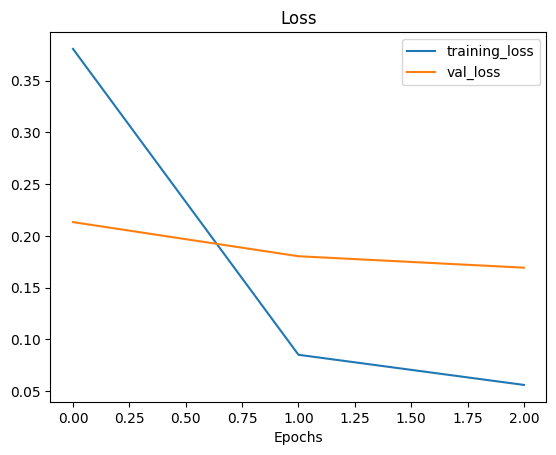

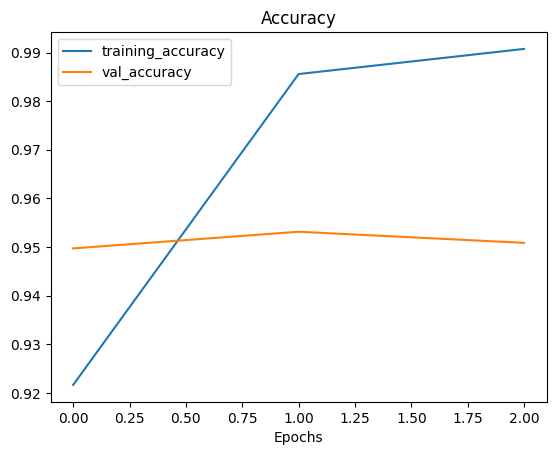

In [14]:
plot_loss_curves(efficientnet_history)

In [15]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['acinonyx-jubatus' 'ailuropoda-melanoleuca' 'canis-lupus-familiaris'
 'equus-caballus' 'felis-catus' 'gallus-gallus-domesticus'
 'panthera-tigris']


1/1 [==============================] - 2s 2s/step


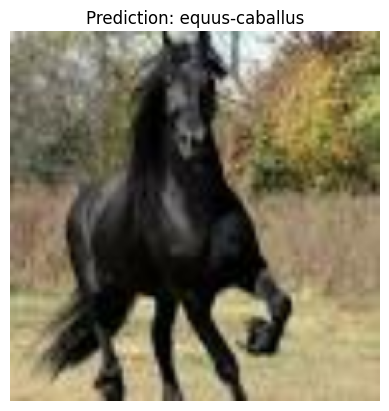

In [16]:
from helper_functions import pred_and_plot
pred_and_plot(resnet_model, "/content/horse2.jpg",class_names)

1/1 [==============================] - 3s 3s/step


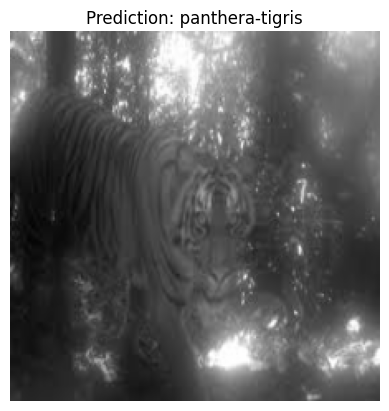

In [17]:
pred_and_plot(efficientnet_model, "tiger.jpg",class_names)

In [18]:
loaded_loss, loaded_accuracy = efficientnet_model.evaluate(test_data)
loaded_loss, loaded_accuracy

28/28 [==============================] - 7s 253ms/step - loss: 0.1214 - accuracy: 0.9634


(0.12140774726867676, 0.9634285569190979)

In [19]:
pred_probs = efficientnet_model.predict(test_data, verbose=1)
pred_probs[:10]

28/28 [==============================] - 8s 249ms/step


array([[9.99103069e-01, 5.45042931e-05, 2.35943735e-04, 6.82287355e-05,
        2.91153447e-05, 1.26202722e-04, 3.82933940e-04],
       [9.93407488e-01, 8.23953713e-04, 1.73971406e-03, 1.18997553e-03,
        5.49650111e-04, 4.77105030e-04, 1.81210355e-03],
       [9.96763349e-01, 6.20949373e-04, 7.75759399e-04, 2.66772346e-04,
        2.50445330e-04, 2.27483499e-04, 1.09512126e-03],
       [9.31745172e-01, 4.16108128e-03, 1.86682288e-02, 7.54080387e-03,
        2.74434732e-03, 1.81856602e-02, 1.69546138e-02],
       [9.59748983e-01, 8.94915836e-04, 2.53285887e-03, 4.11131606e-03,
        1.19624101e-03, 6.59817306e-04, 3.08558680e-02],
       [9.98956561e-01, 1.62966724e-04, 2.05015938e-04, 1.34190908e-04,
        6.90380257e-05, 1.11297835e-04, 3.61020997e-04],
       [9.91224587e-01, 3.11676180e-04, 7.08668167e-03, 1.71819302e-05,
        1.88537597e-04, 1.42138495e-04, 1.02916744e-03],
       [9.83357608e-01, 3.63729720e-04, 2.91747483e-03, 5.43789756e-05,
        1.13730067e-02, 1

In [20]:
len(pred_probs)

875

In [21]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
y_class_names = []
for i in range(len(test_data)):
  images, ylabel = test_data[i] # unbatch the test data and get images and labels
  y_labels.extend(np.argmax(ylabel,axis=1)) # append the index which has the largest value (labels are one-hot)
  y_class_names.extend([class_names[idx] for idx in np.argmax(ylabel,axis=1)])
print("Labels:", y_labels[:10]) # check what they look like (unshuffled)
print("Class Names:", y_class_names[:10])

Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Class Names: ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


In [33]:
len(y_labels)

875

In [34]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.9634285714285714

In [31]:
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: -1.4509473511559179e-08


In [42]:
class_names = class_names.split(",")

In [46]:
class_names

['acinonyx-jubatus',
 'ailuropoda-melanoleuca',
 'canis-lupus-familiaris',
 'equus-caballus',
 'felis-catus',
 'gallus-gallus-domesticus',
 'panthera-tigris']

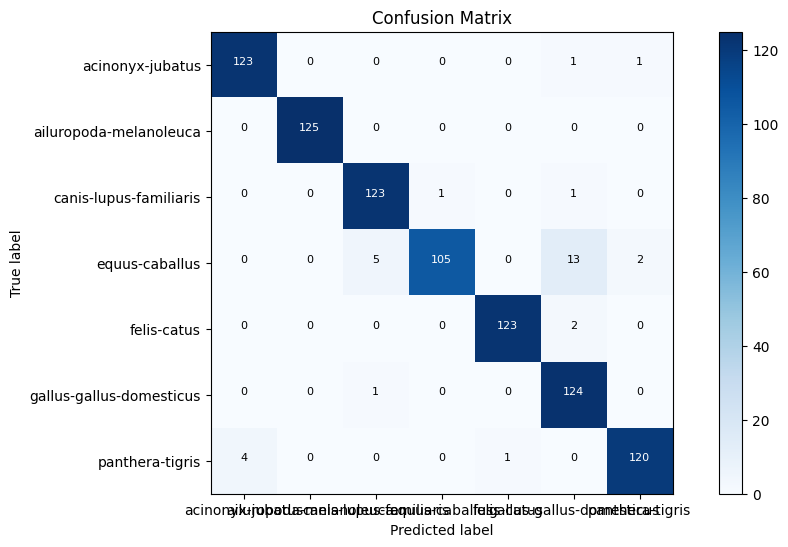

In [48]:
from helper_functions import make_confusion_matrix

# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(12,6),
                      text_size=8,
                      norm=False,
                      savefig=True)

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       125
           1       1.00      1.00      1.00       125
           2       0.95      0.98      0.97       125
           3       0.99      0.84      0.91       125
           4       0.99      0.98      0.99       125
           5       0.88      0.99      0.93       125
           6       0.98      0.96      0.97       125

    accuracy                           0.96       875
   macro avg       0.97      0.96      0.96       875
weighted avg       0.97      0.96      0.96       875



In [50]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.968503937007874,
  'recall': 0.984,
  'f1-score': 0.976190476190476,
  'support': 125},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 125},
 '2': {'precision': 0.9534883720930233,
  'recall': 0.984,
  'f1-score': 0.9685039370078741,
  'support': 125},
 '3': {'precision': 0.9905660377358491,
  'recall': 0.84,
  'f1-score': 0.9090909090909091,
  'support': 125},
 '4': {'precision': 0.9919354838709677,
  'recall': 0.984,
  'f1-score': 0.9879518072289156,
  'support': 125},
 '5': {'precision': 0.8794326241134752,
  'recall': 0.992,
  'f1-score': 0.9323308270676692,
  'support': 125},
 '6': {'precision': 0.975609756097561,
  'recall': 0.96,
  'f1-score': 0.9677419354838709,
  'support': 125},
 'accuracy': 0.9634285714285714,
 'macro avg': {'precision': 0.96564803013125,
  'recall': 0.9634285714285714,
  'f1-score': 0.9631156988671021,
  'support': 875},
 'weighted avg': {'precision': 0.96564803013125,
  'recall': 0.9634285714285714,
  'f1-score': 

In [51]:
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'acinonyx-jubatus': 0.976190476190476,
 'ailuropoda-melanoleuca': 1.0,
 'canis-lupus-familiaris': 0.9685039370078741,
 'equus-caballus': 0.9090909090909091,
 'felis-catus': 0.9879518072289156,
 'gallus-gallus-domesticus': 0.9323308270676692,
 'panthera-tigris': 0.9677419354838709}

In [52]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
1,ailuropoda-melanoleuca,1.000000
4,felis-catus,0.987952
0,acinonyx-jubatus,0.976190
2,canis-lupus-familiaris,0.968504
6,panthera-tigris,0.967742


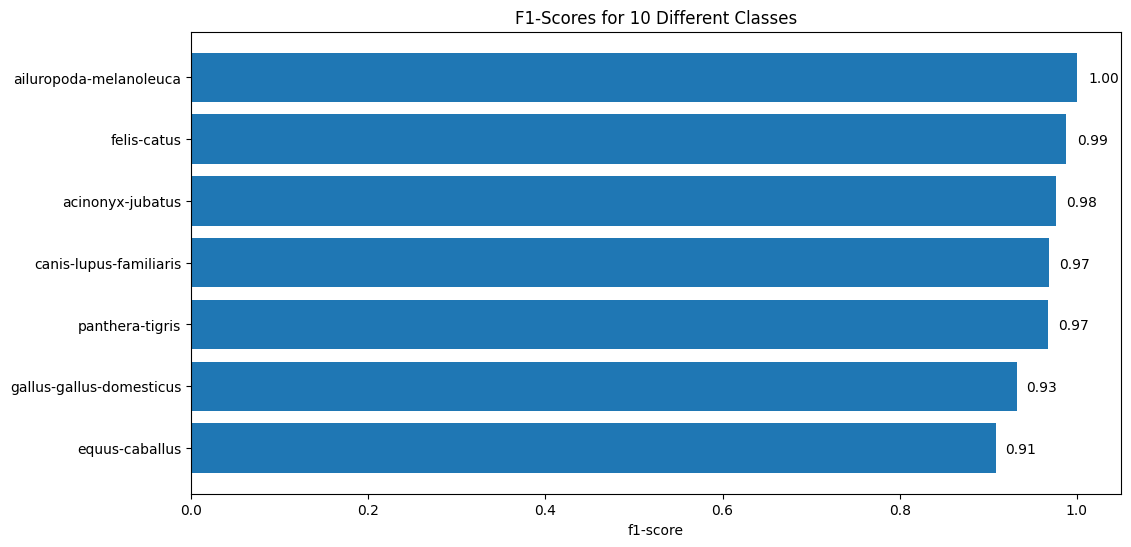

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)


In [56]:
from helper_functions import load_and_prep_image

1/1 [==============================] - 0s 23ms/step


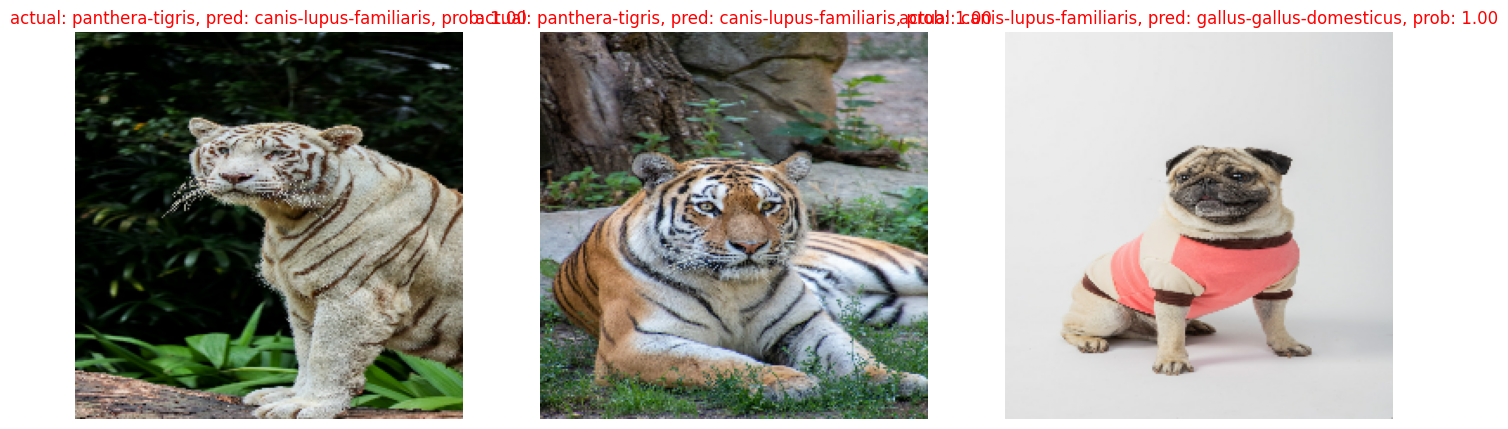

In [70]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = efficientnet_model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [64]:
filepaths = [os.path.join("animals/dataset/test",filename) for filename in test_data.filenames]
filepaths[:10]

['animals/dataset/test/acinonyx-jubatus/photo-1618123305218-c1fa44178634.jpg',
 'animals/dataset/test/acinonyx-jubatus/photo-1618562361717-79994edba86f.jpg',
 'animals/dataset/test/acinonyx-jubatus/photo-1618578895875-b227c29caffa.jpg',
 'animals/dataset/test/acinonyx-jubatus/photo-1618592769372-23f19f05bfaa.jpg',
 'animals/dataset/test/acinonyx-jubatus/photo-1618592771023-9b186ff47988.jpg',
 'animals/dataset/test/acinonyx-jubatus/photo-1618595714614-793e489ce7dd.jpg',
 'animals/dataset/test/acinonyx-jubatus/photo-1618738322758-73b5b812e904.jpg',
 'animals/dataset/test/acinonyx-jubatus/photo-1618792950788-5f0b23e423bb.jpg',
 'animals/dataset/test/acinonyx-jubatus/photo-1618792950877-5d38c85cd755.jpg',
 'animals/dataset/test/acinonyx-jubatus/photo-1618792951599-5b6b994a8c20.jpg']

In [65]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.999103,acinonyx-jubatus,acinonyx-jubatus
1,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.993407,acinonyx-jubatus,acinonyx-jubatus
2,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.996763,acinonyx-jubatus,acinonyx-jubatus
3,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.931745,acinonyx-jubatus,acinonyx-jubatus
4,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.959749,acinonyx-jubatus,acinonyx-jubatus


In [66]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.999103,acinonyx-jubatus,acinonyx-jubatus,True
1,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.993407,acinonyx-jubatus,acinonyx-jubatus,True
2,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.996763,acinonyx-jubatus,acinonyx-jubatus,True
3,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.931745,acinonyx-jubatus,acinonyx-jubatus,True
4,animals/dataset/test/acinonyx-jubatus/photo-16...,0,0,0.959749,acinonyx-jubatus,acinonyx-jubatus,True


In [67]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
759,animals/dataset/test/panthera-tigris/photo-159...,6,0,0.980483,panthera-tigris,acinonyx-jubatus,False
487,animals/dataset/test/equus-caballus/images.jpg,3,5,0.914201,equus-caballus,gallus-gallus-domesticus,False
760,animals/dataset/test/panthera-tigris/photo-159...,6,0,0.910894,panthera-tigris,acinonyx-jubatus,False
444,animals/dataset/test/equus-caballus/images (39...,3,5,0.893872,equus-caballus,gallus-gallus-domesticus,False
545,animals/dataset/test/felis-catus/cats_00829.jpg,4,5,0.871559,felis-catus,gallus-gallus-domesticus,False
786,animals/dataset/test/panthera-tigris/photo-159...,6,4,0.869952,panthera-tigris,felis-catus,False
831,animals/dataset/test/panthera-tigris/photo-160...,6,0,0.838926,panthera-tigris,acinonyx-jubatus,False
445,animals/dataset/test/equus-caballus/images (4)...,3,2,0.798889,equus-caballus,canis-lupus-familiaris,False
460,animals/dataset/test/equus-caballus/images (53...,3,5,0.716481,equus-caballus,gallus-gallus-domesticus,False
406,animals/dataset/test/equus-caballus/horse-tria...,3,2,0.695410,equus-caballus,canis-lupus-familiaris,False


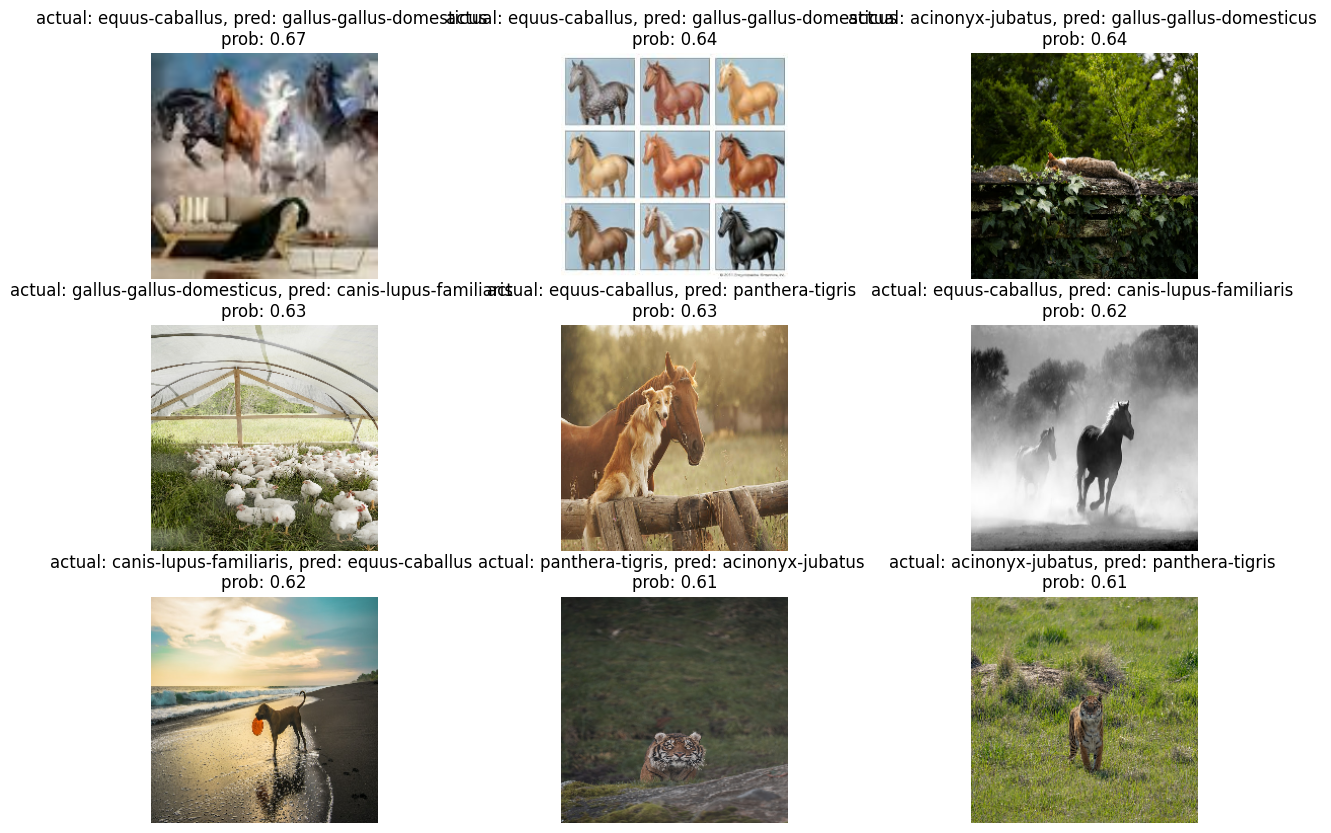

In [68]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)